<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/CNN%E3%81%AB%E3%82%88%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%EF%BC%88%E3%83%9E%E3%83%8F%E3%83%A9%E3%83%8E%E3%83%93%E3%82%B9%E8%B7%9D%E9%9B%A2%E7%89%88%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 238MB/s]
100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting features...
Feature shapes: torch.Size([4500, 512]) torch.Size([500, 512]) torch.Size([1000, 512]) torch.Size([9000, 512])
Threshold (val normal 99.0th pct): 73.22247
AUC = 0.9018, AP = 0.9873, Accuracy@thr = 0.4656
Mean scores -> normal: 52.4502, anomaly: 70.6347


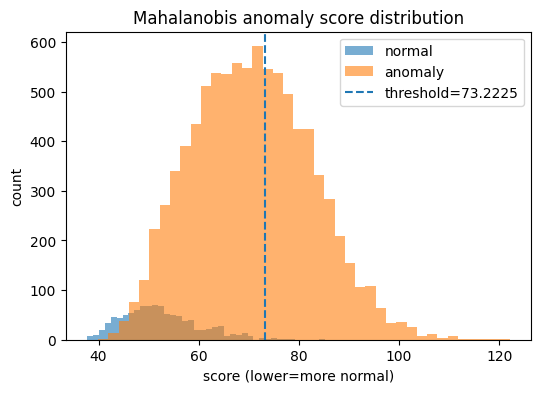

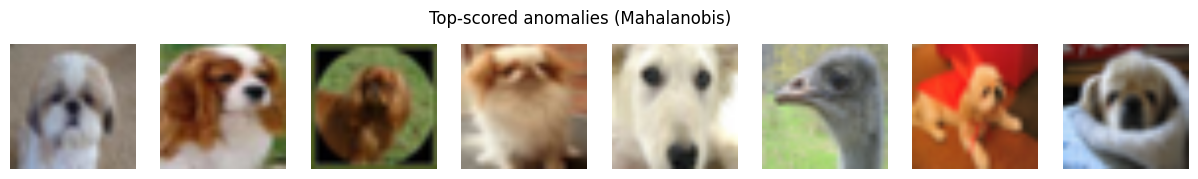

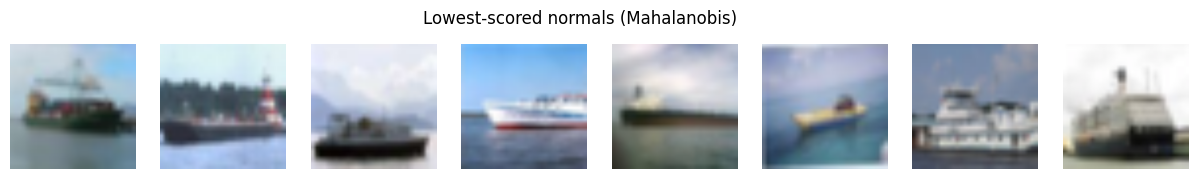

Saved: cnn_backbone_mahalanobis_scores.csv


In [1]:
# Colab-ready: CNN backbone (ResNet18) + Mahalanobis distance anomaly detection
import os, math, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

# (必要なら) 評価指標と共分散縮小のために scikit-learn を使用
# !pip -q install scikit-learn
from sklearn.metrics import roc_auc_score, average_precision_score
try:
    from sklearn.covariance import LedoitWolf
    HAS_LW = True
except Exception:
    HAS_LW = False

# ============ Parameters ============
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
NUM_WORKERS = 2
NORMAL_CLASS = "ship"     # CIFAR-10 の正常クラス（例: 'airplane','automobile','bird',...,'truck'）
VAL_SPLIT = 0.1           # 正常学習の一部をバリデーションに回す割合（しきい値決定用）
THRESH_PCT = 99.0         # バリデーション正常スコアの上位分位点をしきい値に
RANDOM_SEED = 1337

random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)

# ============ Transforms (ImageNet 正規化) ============
IM_SIZE = 224
IM_MEAN = [0.485, 0.456, 0.406]
IM_STD  = [0.229, 0.224, 0.225]
t_train = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IM_MEAN, IM_STD),
])
t_test = t_train

# ============ Backbone: ResNet18 (ImageNet pretrained) ============
try:
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    backbone = models.resnet18(weights=weights)
except Exception:
    backbone = models.resnet18(pretrained=True)  # 互換 fallback
backbone.fc = nn.Identity()   # 512-d features
backbone.eval().to(DEVICE)
for p in backbone.parameters(): p.requires_grad_(False)

# ============ Dataset (CIFAR-10 デモ) ============
root = "./data"
train_set = datasets.CIFAR10(root, train=True,  download=True, transform=t_train)
test_set  = datasets.CIFAR10(root, train=False, download=True, transform=t_test)
classes = train_set.classes
normal_idx = classes.index(NORMAL_CLASS)

tr_idx_norm = [i for i,(_,y) in enumerate(train_set) if y == normal_idx]
te_idx_norm = [i for i,(_,y) in enumerate(test_set)  if y == normal_idx]
te_idx_anom = [i for i,(_,y) in enumerate(test_set)  if y != normal_idx]

# 正常学習を (feature bank) / (validation) に分割
n_val = max(1, int(len(tr_idx_norm) * VAL_SPLIT))
tr_idx_norm_shuffled = tr_idx_norm.copy()
random.shuffle(tr_idx_norm_shuffled)
val_idx_norm = tr_idx_norm_shuffled[:n_val]
bank_idx_norm = tr_idx_norm_shuffled[n_val:]

ds_bank = Subset(train_set, bank_idx_norm)   # 正常のみ（平均・共分散の推定に使用）
ds_val  = Subset(train_set, val_idx_norm)    # しきい値決定用（正常のみ）
ds_test_norm  = Subset(test_set, te_idx_norm)
ds_test_anom  = Subset(test_set, te_idx_anom)

def mk_loader(ds, shuffle=False):
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=NUM_WORKERS,
                      pin_memory=(DEVICE=="cuda"))
ld_bank = mk_loader(ds_bank)
ld_val  = mk_loader(ds_val)
ld_tn   = mk_loader(ds_test_norm)
ld_ta   = mk_loader(ds_test_anom)

# ============ Feature extraction ============
@torch.no_grad()
def extract_features(loader):
    feats = []
    for x, *rest in loader:
        x = x.to(DEVICE, non_blocking=True)
        f = backbone(x)            # [B, 512]
        feats.append(f.cpu().to(torch.float64))  # 数値安定のため float64
    return torch.cat(feats, dim=0)  # [N, D]

print("Extracting features...")
F_bank = extract_features(ld_bank)   # 正常のみ
F_val  = extract_features(ld_val)    # 正常のみ
F_tn   = extract_features(ld_tn)
F_ta   = extract_features(ld_ta)
D = F_bank.shape[1]
print("Feature shapes:", F_bank.shape, F_val.shape, F_tn.shape, F_ta.shape)

# ============ Mahalanobis: 平均・共分散（縮小推定） ============
mu = F_bank.mean(dim=0).numpy()                   # (D,)
Xc = (F_bank.numpy() - mu)                        # [N, D]

if HAS_LW and Xc.shape[0] > Xc.shape[1]:
    # Ledoit-Wolf で PSD かつ安定な共分散推定
    lw = LedoitWolf().fit(Xc)
    Sigma = lw.covariance_
else:
    # Fallback: ridge-shrinked covariance: (1-α)S + α·(tr(S)/D)·I
    S = (Xc.T @ Xc) / max(1, Xc.shape[0] - 1)     # 標本共分散
    tr_over_d = np.trace(S) / D
    alpha = 0.1                                   # 収縮強度は状況で調整
    Sigma = (1 - alpha) * S + alpha * tr_over_d * np.eye(D)

# 逆行列（必要ならさらに微小正則化）
eps = 1e-6 * np.trace(Sigma) / D
Sigma_inv = np.linalg.inv(Sigma + eps * np.eye(D))

def mahalanobis_scores(F_query, mu, Sigma_inv):
    X = F_query.numpy().astype(np.float64)
    diff = X - mu[None, :]
    # M^2 = (x-μ)^T Σ^{-1} (x-μ)
    m2 = np.einsum("nd,dd,nd->n", diff, Sigma_inv, diff)
    # 数値誤差で負になったら 0 に
    m2 = np.maximum(m2, 0.0)
    return np.sqrt(m2)  # M-distance（平方根）。平方のままでも可。

# ============ Score & threshold ============
val_scores = mahalanobis_scores(F_val, mu, Sigma_inv)
tn_scores  = mahalanobis_scores(F_tn,  mu, Sigma_inv)
ta_scores  = mahalanobis_scores(F_ta,  mu, Sigma_inv)

thr = np.percentile(val_scores, THRESH_PCT)
print(f"Threshold (val normal {THRESH_PCT:.1f}th pct): {thr:.5f}")

# ============ Eval (デモ用) ============
y_tn = np.zeros_like(tn_scores, dtype=int)
y_ta = np.ones_like(ta_scores, dtype=int)
scores = np.concatenate([tn_scores, ta_scores])
labels = np.concatenate([y_tn, y_ta])

auc = roc_auc_score(labels, scores)
ap  = average_precision_score(labels, scores)
pred = (scores >= thr).astype(int)
acc = (pred == labels).mean()
print(f"AUC = {auc:.4f}, AP = {ap:.4f}, Accuracy@thr = {acc:.4f}")
print(f"Mean scores -> normal: {tn_scores.mean():.4f}, anomaly: {ta_scores.mean():.4f}")

# ============ Plots ============
plt.figure(figsize=(6,4))
plt.hist(tn_scores, bins=40, alpha=0.6, label="normal")
plt.hist(ta_scores, bins=40, alpha=0.6, label="anomaly")
plt.axvline(thr, linestyle="--", label=f"threshold={thr:.4f}")
plt.title("Mahalanobis anomaly score distribution")
plt.xlabel("score (lower=more normal)")
plt.ylabel("count")
plt.legend(); plt.show()

# ============ Inspect samples ============
def inv_norm(x):
    mean = torch.tensor(IM_MEAN).view(3,1,1); std = torch.tensor(IM_STD).view(3,1,1)
    return (x*std + mean).clamp(0,1)

def show_samples(dataset_subset, scores_arr, title, n=8, highest=True):
    idx_sorted = np.argsort(scores_arr)
    if highest: idx_sorted = idx_sorted[::-1]
    idx_pick = set(idx_sorted[:n].tolist())
    loader = DataLoader(dataset_subset, batch_size=1, shuffle=False, num_workers=0)
    imgs = []
    for i, (x, *_) in enumerate(loader):
        if i in idx_pick:
            imgs.append(inv_norm(x[0]).permute(1,2,0).numpy())
        if len(imgs) >= n: break
    cols = n
    plt.figure(figsize=(1.9*cols, 2.0))
    for i,img in enumerate(imgs):
        plt.subplot(1, cols, i+1); plt.imshow(img); plt.axis("off")
    plt.suptitle(title); plt.show()

show_samples(ds_test_anom, ta_scores, "Top-scored anomalies (Mahalanobis)", n=8, highest=True)
show_samples(ds_test_norm, tn_scores, "Lowest-scored normals (Mahalanobis)", n=8, highest=False)

# ============ Save CSV ============
df = pd.DataFrame({"score": scores, "label": labels, "pred@thr": pred})
df.to_csv("cnn_backbone_mahalanobis_scores.csv", index=False)
print("Saved: cnn_backbone_mahalanobis_scores.csv")

# ======= Notes =======
# - 特徴は L2 正規化しません（Mahalanobis は共分散でスケールを扱うため）。
# - 共分散は Ledoit-Wolf（利用可なら）か、ridge 収縮で安定化。
# - しきい値は正常バリデーションの分位点で決定（用途に応じて変更）。
# - 実運用では正常のみで mu, Sigma を確定し、推論画像の距離が閾値以上なら異常と判定します。
